In [6]:
import numpy as np
import pandas as pd
import os
import re
import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from pathlib import Path

volume_paths = []
segmentation_paths = []

def list_files_pathlib(path, output_list):
    for entry in path.iterdir():
        if entry.is_file():
            output_list.append(entry)

        elif entry.is_dir() and not str(entry).endswith("segmentations"):
            list_files_pathlib(entry, output_list)

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

list_files_pathlib(Path('/kaggle/input'), volume_paths)
list_files_pathlib(Path("/kaggle/input/liver-tumor-segmentation/segmentations"), segmentation_paths)

volume_paths_sorted = sorted(volume_paths, key=lambda x: natural_sort_key(str(x)[str(x).find("volume")+5:]))
segmentation_paths = sorted(segmentation_paths, key=lambda x: natural_sort_key(str(x)))

In [3]:
data = pd.DataFrame(
    {
        "volumes": volume_paths_sorted,
        "segmentations": segmentation_paths
    })
data.head(4)

,volumes,segmentations
0,/kaggle/input/liver-tumor-segmentation/volume_...,/kaggle/input/liver-tumor-segmentation/segment...
1,/kaggle/input/liver-tumor-segmentation/volume_...,/kaggle/input/liver-tumor-segmentation/segment...
2,/kaggle/input/liver-tumor-segmentation/volume_...,/kaggle/input/liver-tumor-segmentation/segment...
3,/kaggle/input/liver-tumor-segmentation/volume_...,/kaggle/input/liver-tumor-segmentation/segment...


In [10]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import Image, display, HTML
%matplotlib inline

def read_nii(filepath, mmap = False, rotate = False):
    ct_scan = nib.load(filepath, mmap=mmap)
    array   = ct_scan.get_fdata()
    if rotate:
        array   = np.rot90(np.array(array))
    return(array)

def update(frame, vol_plot, seg_plot, volume, segment):
    vol_plot.set_array(volume[:,:,frame])  # Update the image data
    seg_plot.set_array(segment[:,:,frame])
    return [vol_plot, seg_plot]

def animate_sample(sample):
    volume = read_nii(str(data.iloc[sample]["volumes"]), rotate = True)
    segment = read_nii(str(data.iloc[sample]["segmentations"]), rotate = True)
    fig, ax = plt.subplots(1, 2)
    
    ims = []
    for i in range(volume.shape[2]):
        im1 = ax[0].imshow(volume[:,:,i], cmap = "bone")
        im2 = ax[1].imshow(segment[:,:,i], cmap = "bone")
        # Frame has to be set directly, using set_text doesn't work
        frame_text = ax[0].text(0.5, 1.05, f'Frame: {i}', transform=ax[0].transAxes, ha='center', fontsize=15, color='black')
        ims.append([im1,im2, frame_text])


    # create and save the animation as GIF
    ani = ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    gif_path = './animation.gif'
    ani.save(gif_path, writer='imagemagick', fps=5)

    # Close the figure after saving the GIF, it shows an additional plot of the last frame if not
    plt.close(fig)

    # display the gif
    display(HTML(f'<img src="{gif_path}" />'))

def plot_sample(sample, slice):
    volume = read_nii(str(data.iloc[sample]["volumes"]), rotate = True)
    segment = read_nii(str(data.iloc[sample]["segmentations"]), rotate = True)
    fig, ax = plt.subplots(1, 2)
    vol_plot = ax[0].imshow(volume[:,:,slice], cmap = "bone")
    seg_plot = ax[1].imshow(segment[:,:,slice],cmap = "bone")
    plt.show()

    

In [11]:
animate_sample(0)

In [23]:
read_nii(str(data.iloc[9]["volumes"])).shape

(512, 512, 549)

In [12]:
# dataset contains 67072 slices
total = 67072 
batch_size = 8
percentage_of_data = 0.30 # take a fraaction of the dataset (too long might die waiting)
resize_image_to = 128

In [13]:
import tensorflow as tf


def slice_generator(file_paths_volume, file_paths_segment):
    for vol_path, seg_path in zip(file_paths_volume, file_paths_segment):
        # Load the volume and segmentation using nibabel

        
        volume = read_nii(str(vol_path), mmap = True)
        segmentation = read_nii(str(seg_path), mmap = True)
        volume_resized = []
        segment_resized = []
        for i in range(volume.shape[2]):

            # preprocess volumes
            temp = (volume[:,:,i] - np.min(volume[:,:,i])) / (np.max(volume[:,:,i]) - np.min(volume[:,:,i]))
            
            temp = temp.astype(np.uint8)
            
            # histogram equalization
            clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8, 8))
            temp = clahe.apply(np.array(temp))   
            temp = cv2.resize(temp, (resize_image_to, resize_image_to))
            temp[temp > 1] = 1
            temp[temp < 0]  = 0
            volume_resized.append(temp)

            # preprocess segmentations
            temp = segmentation[:,:,i]

            # clamp the values > 1, there are values of 2 in the segments
            # I think they're supposed to be tumors but I don't care about that right now.
            temp[temp > 1] = 1
            temp[temp < 0]  = 0
                
            temp = temp.astype(np.uint8)
            temp = cv2.resize(temp, (resize_image_to, resize_image_to))
            segment_resized.append(temp)
        
        del volume
        del segmentation
        # expand the dims to have shape (128, 128, 1), matching the expected output of the generator
        volume_resized = np.expand_dims(volume_resized, axis=-1) 
        segment_resized = np.expand_dims(segment_resized, axis=-1)

        
        for i in range(volume_resized.shape[0]):
            volume_slice = volume_resized[i]
            segmentation_slice = segment_resized[i]
            yield volume_slice, segmentation_slice



# Create a tf.data.Dataset from the generator
def create_lazy_dataset(file_paths_volume, file_paths_segment):
    # Wrap the generator
    dataset = tf.data.Dataset.from_generator(
        lambda: slice_generator(file_paths_volume, file_paths_segment),  # Generator function
        output_signature=(

        # the shape of the generator is set with an additional parameter channel of one so a Conv2D can interpret it as grayscale
        tf.TensorSpec(shape=(resize_image_to,resize_image_to, 1), dtype=tf.float32),  # Shape of volume
        tf.TensorSpec(shape=(resize_image_to,resize_image_to, 1), dtype=tf.float32)   # Shape of segmentation
    )
    )
    

    return dataset

dataset = create_lazy_dataset(data["volumes"], data["segmentations"])

total_of_percentage = int(0.2 * total)
dataset = dataset.take(total_of_percentage)

dataset = dataset.shuffle(buffer_size=100, reshuffle_each_iteration=False)
train_dataset = dataset.take(int(0.8 * total_of_percentage))
val_dataset = dataset.skip(int(0.8 * total_of_percentage)).take(int(0.1 *total))
test_dataset = dataset.skip(int(total_of_percentage * 0.9))

train_dataset = train_dataset.cache() 
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [14]:
from keras import layers, Model, Input
import keras


def get_model(img_size):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


img_size = (resize_image_to,resize_image_to, 1)

model = get_model(img_size)


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy"
)

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch= int(0.8 * total_of_percentage // batch_size),  
    validation_steps=int(0.1 *total_of_percentage // batch_size),
    callbacks=callbacks
)

Epoch 1/5


I0000 00:00:1733404631.931429     101 service.cc:145] XLA service 0x7f49640029f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733404631.931481     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733404631.931485     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   5/1341 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - loss: 0.9951  

I0000 00:00:1733404644.512689     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1341/1341 ━━━━━━━━━━━━━━━━━━━━ 236s 158ms/step - loss: 0.0769 - val_loss: 0.0763
Epoch 2/5
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - loss: 0.0680 - val_loss: 0.0723
Epoch 3/5
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 0.0686 - val_loss: 0.0799
Epoch 4/5
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 0.0714 - val_loss: 0.0715
Epoch 5/5
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - loss: 0.0728 - val_loss: 0.0842


In [17]:
test_dataset_volumes = test_dataset.map(lambda x, y: x)  # x is the volume, y is the segmentation

# Predict using the model
predictions = model.predict(test_dataset_volumes)

168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 68ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
def plot_sample(sample, slice):
    volume = read_nii(str(data.iloc[sample]["volumes"]), rotate = True)
    segment = read_nii(str(data.iloc[sample]["segmentations"]), rotate = True)
    fig, ax = plt.subplots(1, 2)
    vol_plot = ax[0].imshow(volume[:,:,slice], cmap = "bone")
    seg_plot = ax[1].imshow(segment[:,:,slice],cmap = "bone")
    plt.show()

In [30]:
real_test_segments = test_dataset.map(lambda x, y: y)

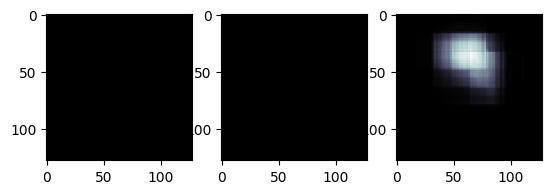

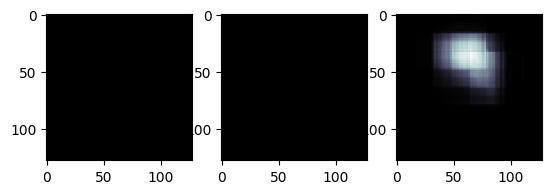

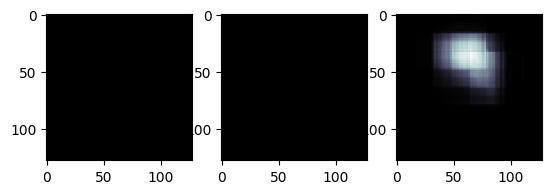

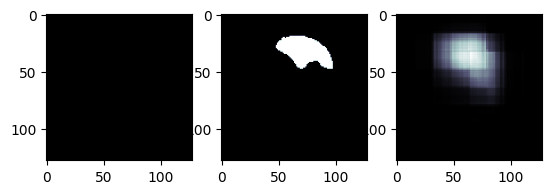

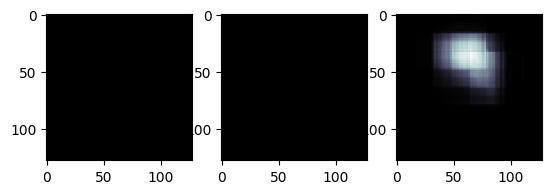

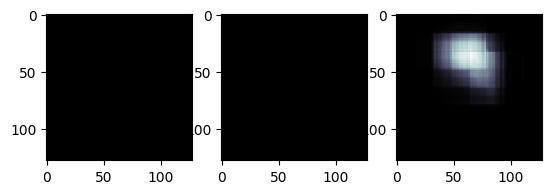

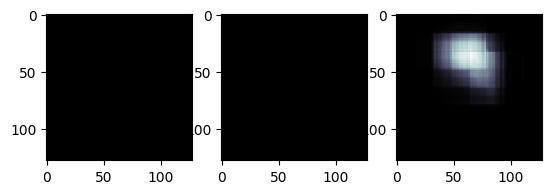

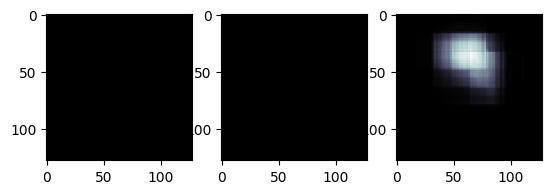

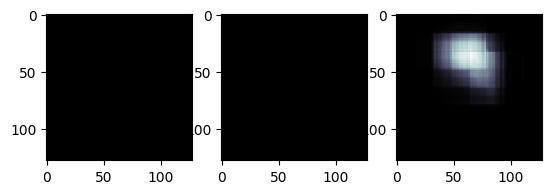

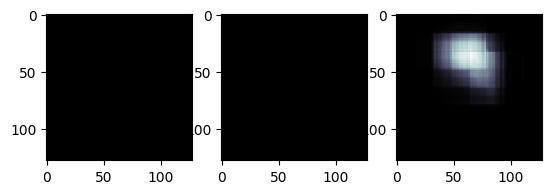

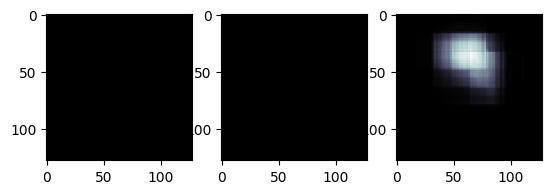

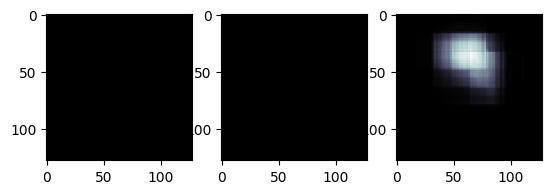

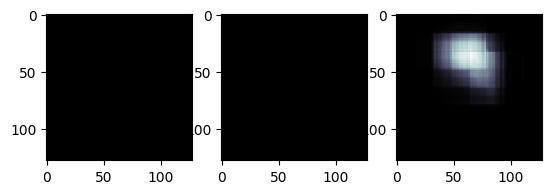

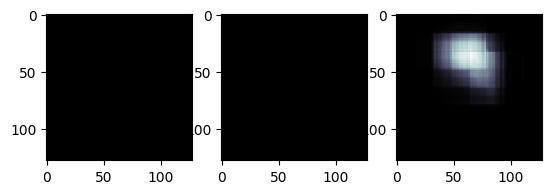

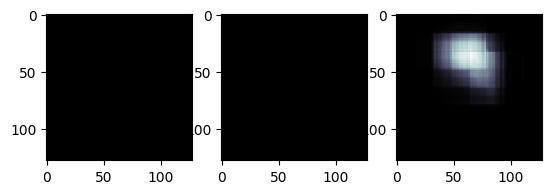

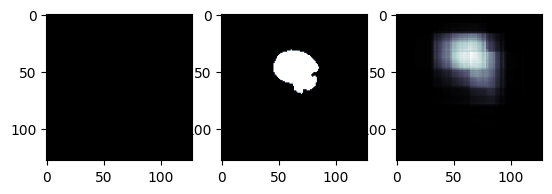

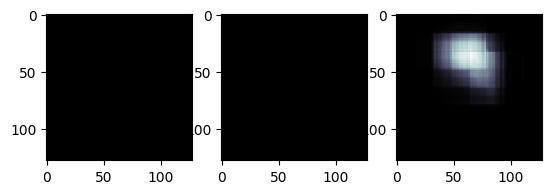

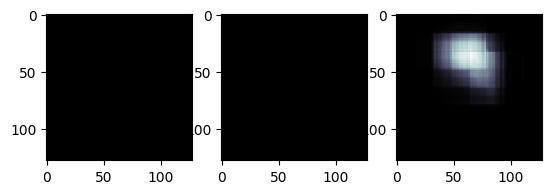

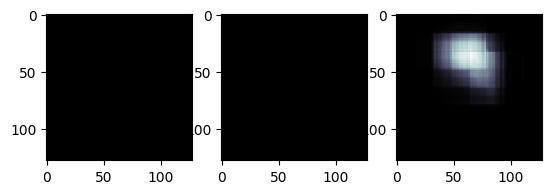

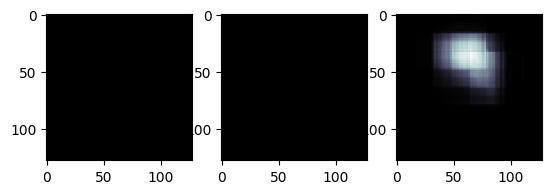

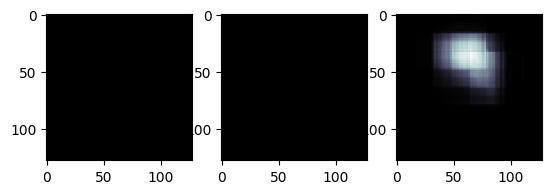

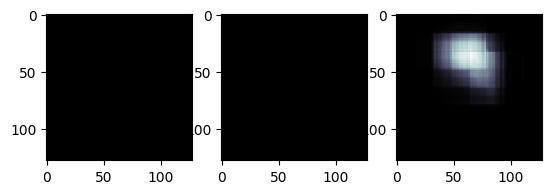

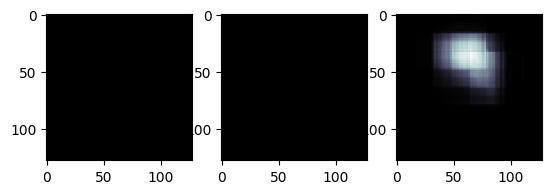

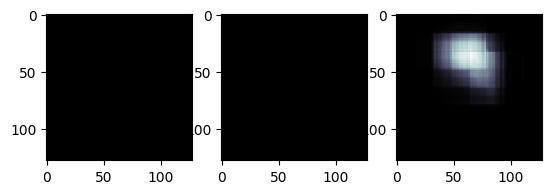

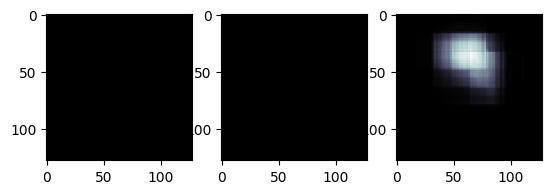

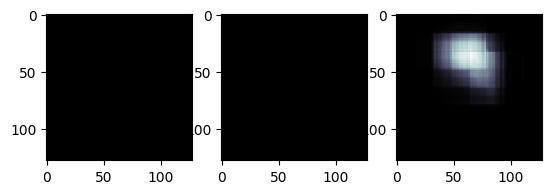

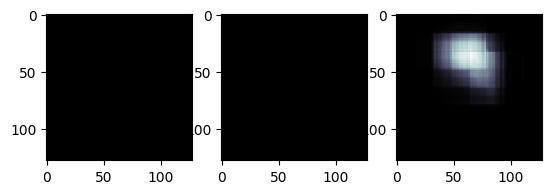

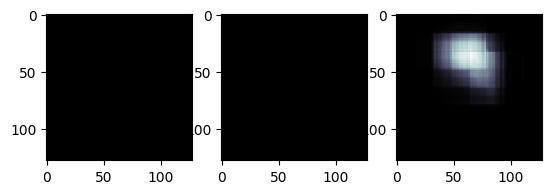

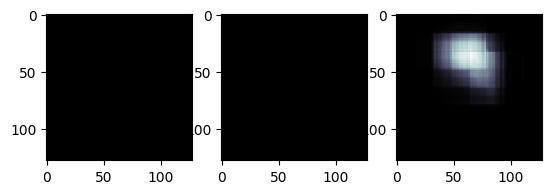

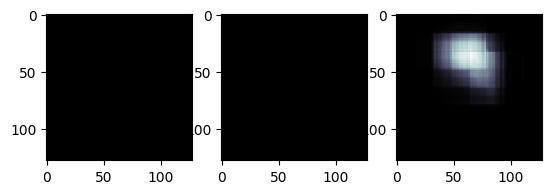

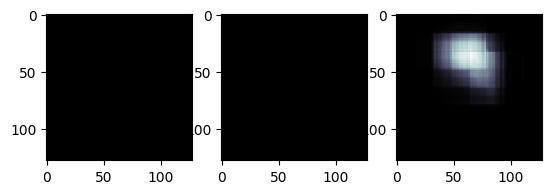

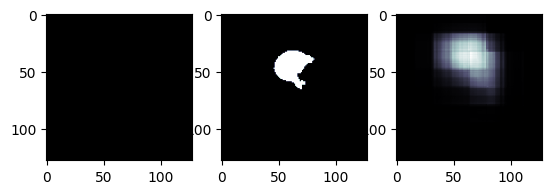

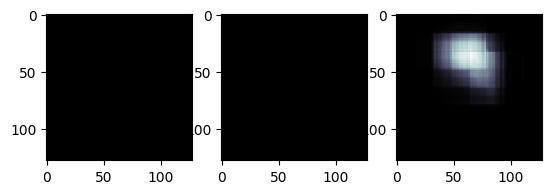

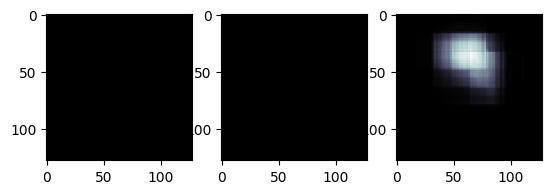

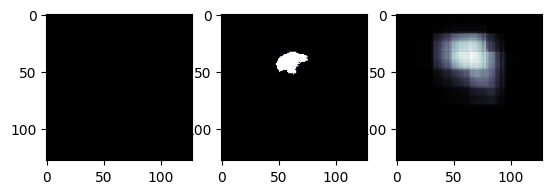

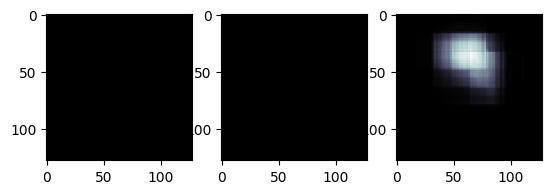

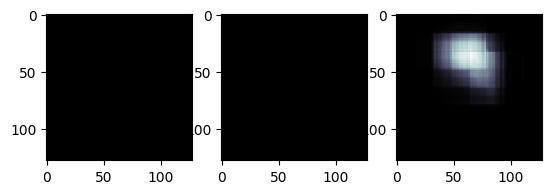

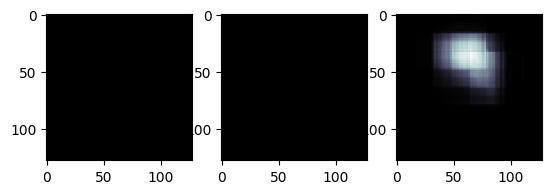

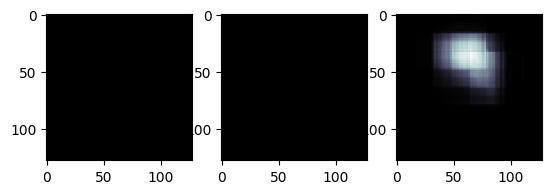

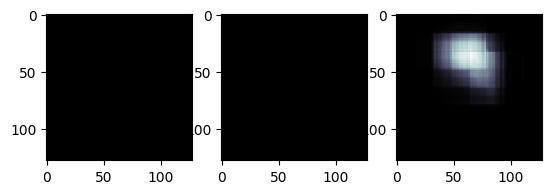

In [39]:
count = 0
for i, (volume, segment) in enumerate(test_dataset.take(5)):
    for vol_slice, seg_slice in zip(volume, segment):
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(vol_slice, cmap = "bone")
        ax[1].imshow(seg_slice, cmap = "bone")
        ax[2].imshow(predictions[count], cmap = "bone")
        plt.show()
        count += 1


In [31]:
realsegment_list = list(real_test_segments)

In [35]:
realsegment_list[3].shape

TensorShape([8, 128, 128, 1])

In [ ]:
def plot_sample(sample, slice):
    volume = read_nii(str(data.iloc[sample]["volumes"]))
    segment = read_nii(str(data.iloc[sample]["segmentations"]))
    fig, ax = plt.subplots(1, 2)
    vol_plot = ax[0].imshow(volume[:,:,slice], cmap = "bone")
    seg_plot = ax[1].imshow(segment[:,:,slice],cmap = "bone")
    plt.show()
